In [1]:
import os, re, shutil, json, time
import jieba, numpy
import string, gensim
import threading
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec
from collections import Counter
from tqdm import tqdm

In [2]:
def extract_jfull(filename: str):
    with open(os.path.join(dirpath + '/drug_case', filename), "r", encoding = 'UTF-8') as f:
        data = json.load(f)['JFULL']
        data = data.replace(' ', '').replace('　', '')
    target0 = data.find('主文\r\n')
    # 如果案字帶有秩的，代表為社會秩序維護法的案子，並不在我們的管理範圍內
    if "秩" in filename: 
        return ""
    
    # 如果 JFULL 找不到主文，那就代表是 pdf 檔案
    # 暫定不處置
    if target0 != -1:
        target1 = []
        if data.find('事實及理由\r\n') != -1:
            target1.append(data.find('事實及理由\r\n', target0))
        if data.find('犯罪事實\r\n') != -1:
            target1.append(data.find('犯罪事實\r\n', target0))
        if data.find('理由\r\n') != -1:
            target1.append(data.find('理由\r\n', target0))
        if data.find('事實\r\n') != -1:
            target1.append(data.find('事實\r\n', target0))
        if data.find('中華民國') != -1:
            target1.append(data.find('中華民國', target0))
        target1 = min(target1)
        target2 = data.find('書記官')
        
        data = data[target1: target2].replace('\r\n', '')
        #data = data[target2: data.find('附件', target2)].replace('\r\n', '')
        data = data.replace(' ', '')
        return data
    else:
        return ""

In [3]:
def str_preprocessing(name, result_str_seq):
    return_list = []
    location1, location2 = 0, 0
    result_lawcode = ''
    
    #若原來字串第一個為第X條第X項，則截取第X條的部分
    if len(result_str_seq[0]) > 5:
        location1 = result_str_seq[0].find('第')
        location2 = result_str_seq[0].find('第', location1)
        # print(result_str_seq[0][location1: location2])
        result_lawcode = result_str_seq[0][location1: location2]
        
    for idx in range(len(result_str_seq)):
        # 如果切割出來的字串長度超過 7 就砍到剩下 7 
        # 之後看到項就截取到項，否則就看有沒有條
        result_str = result_str_seq[idx]
        if len(result_str) > 7: result_str = result_str[:7]
        if "項" in result_str: result_str = result_str[: result_str.find('項') + 1]
        else: result_str = result_str[: result_str.find('條') + 1]

        # TODO: 單純「第X項」的沒有處理好
        if len(result_str) > 5 and result_str[0] == '第' and result_str[-1] == '項':
            result_str = result_lawcode + result_str
        for j in ["第" + str(k) + "條" for k in range(4, 18)]:
            if j in result_str:
                return_list.append(result_str)
    #print(i, return_list)
    return return_list

In [4]:
desktop = os.environ['USERPROFILE'] + '/Desktop'
dirpath = desktop + '/Drug_NLP'
result_dict = {}

model = Doc2Vec.load(dirpath + "/drug_model.bin")
caselist = open(dirpath + '/label.txt', 'r', encoding = 'utf-8').readlines()
label = {}
train, train_label = [], []
vector = ['第4條第1項', '第4條第2項', '第4條第3項', '第4條第4項', '第4條第5項', '第4條第6項', '第5條第1項', '第5條第2項', '第5條第3項', '第6條第2項', '第6條第3項', '第6條第4項', '第6條第5項', '第8條第1項', '第8條第2項', '第8條第3項', '第8條第4項', '第8條第5項', '第8條第6項', '第9條第1項', '第9條第2項', '第9條第3項', '第10條第1項', '第10條第2項', '第11條第1項', '第11條第2項', '第11條第3項', '第11條第4項', '第11條第5項', '第11條第6項', '第11條第7項', '第12條第2項', '第13條第2項', '第14條第2項', '第14條第3項', '第14條第4項', '第17條第1項', '第17條第2項', '第17條第3項']


for i in tqdm(caselist):
    filename, sencnt = i.split()
    label[filename] = sencnt
    text = extract_jfull(filename)
    text = text.replace('第1、2項', '第1項、第2項').replace('第3、4項', '第3項、第4項') \
            .replace('條條', '條').replace('第第', '第').replace('２', '2')
    for j in ["條" + str(k) + "項" for k in range(7)]:
        text = text.replace(j, j[0] + "第" + j[1:])
    textloc2 = 0
    all_result_str_seq = []

    while 1:
        textloc1 = text.find('毒品危害防制條例第', textloc2)
        if textloc1 == -1: break
        tmp = text[textloc1: textloc1 + 30]
        if "刑法" in tmp: tmp = tmp[: tmp.find('刑法')]
        textloc2 = max(tmp.rfind('項'), (tmp.rfind('項') == -1) * tmp.rfind('條'))
        if textloc2 == -1: continue
        result_str_seq = text[textloc1 + 8: textloc1 + textloc2 + 1].split('、')
        
        result_str_seq = str_preprocessing(i, result_str_seq)
        all_result_str_seq.extend(result_str_seq)
        all_result_str_seq = list(set(all_result_str_seq) & set(vector))
        
        text_vector = [0] * 39
        for result_str in all_result_str_seq:
            text_vector[vector.index(result_str)] += 1
        textloc2 = textloc1 + textloc2 + 1
    if len(all_result_str_seq) == 0: continue
    else: 
        train.append(text_vector)
        train_label.append(sencnt)
    #print(filename, sencnt, text_vector)


100%|███████████████████████████████████████████████████████████████████████████| 23112/23112 [01:13<00:00, 313.54it/s]


# Sort the vector strings

```python
sorted_result_dict = sorted(list(result_dict), key = result_dict.get, reverse = 1)
vector = ['第10條第2項', '第17條第2項', '第10條第1項', '第17條第1項', '第4條第2項', '第11條第2項', '第4條第1項', '第4條第3項', '第8條第2項', '第4條第6項', '第11條第1項', '第11條第5項', '第8條第6項', '第11條第4項', '第8條第1項', '第11條第3項', '第8條第3項', '第9條第1項', '第5條第2項', '第12條第2項', '第4條第4項', '第5條第3項', '第17條第3項', '第14條第4項', '第9條第3項', '第5條第1項', '第13條第2項', '第11條第6項', '第6條第3項', '第6條第2項', '第8條第5項', '第8條第4項', '第4條第5項', '第9條第2項', '第14條第2項', '第14條第3項', '第6條第5項', '第6條第4項', '第11條第7項']
print(len(vector))
for i in sorted_result_dict:
    if len(re.findall(r'\d+', i)) == 2 and "項" in i and "地" not in i:
        vector.append(i)
vector = sorted(vector, key = lambda x: list(map(int, re.findall(r'\d+', x))))
```

In [5]:
print(len(train), len(train_label))

21991 21991


In [6]:
train = np.array(train)
train_label = np.array(train_label)
print(train.shape, train_label.shape)

(21991, 39) (21991,)


## Create Dataset

In [7]:
import torch
from torch.utils.data import Dataset

class DrugDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.float)
            self.label = torch.FloatTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

In [8]:
VAL_RATIO = 0.1

percent = int(train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (19791, 39)
Size of validation set: (2200, 39)


Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

In [9]:
BATCH_SIZE = 256

from torch.utils.data import DataLoader

train_set = DrugDataset(train_x, train_y)
val_set = DrugDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

C:\Users\terry\AppData\Local\Temp/ipykernel_2296/604575324.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.float)


Cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later<br>the data size is quite huge, so be aware of memory usage in colab**

## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [10]:
import torch as t
import torch.nn as nn

class NN(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NN, self).__init__()

        self.net = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
        )
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x)

## Training

In [11]:
#check device
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cuda


Feel free to change the training parameters here.

In [12]:
model = NN(39).to(device)
model.device = device
if os.path.exists('best_weight.pth'):
    try:
        model.load_state_dict(torch.load('best_weight.pth'))
    except: 
        print('The model weight does not exist!')

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4, weight_decay = 1e-5)

# The number of training epochs.
n_epochs = 100
best_loss = 1000.0
train_loss_record = []
valid_loss_record = []

for epoch in range(n_epochs):
    model.train()
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(torch.squeeze(logits), labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        # Record the loss and accuracy.
        train_loss.append(loss.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_loss_record.append(train_loss)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    valid_loss = []

    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
        imgs, labels = batch
        with torch.no_grad():
            logits = model(imgs.to(device))
        loss = criterion(torch.squeeze(logits), labels.to(device))
        valid_loss.append(loss.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_loss_record.append(valid_loss)
    
    if valid_loss < best_loss:
        print("best loss updated!")
        print(valid_loss, best_loss)
        best_model = model
        best_loss = valid_loss
        torch.save(model.state_dict(), "best_weight.pth")

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}")
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}")

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.43it/s]


best loss updated!
844.1831171247694 1000.0
[ Train | 001/100 ] loss = 400.97827
[ Valid | 001/100 ] loss = 844.18312


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 473.27it/s]


[ Train | 002/100 ] loss = 387.15764
[ Valid | 002/100 ] loss = 855.52146


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.33it/s]


[ Train | 003/100 ] loss = 378.71814
[ Valid | 003/100 ] loss = 975.22187


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.95it/s]


[ Train | 004/100 ] loss = 371.51157
[ Valid | 004/100 ] loss = 871.29073


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.55it/s]


[ Train | 005/100 ] loss = 371.81459
[ Valid | 005/100 ] loss = 1259.08520


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.47it/s]


best loss updated!
821.0456328392029 844.1831171247694
[ Train | 006/100 ] loss = 359.55149
[ Valid | 006/100 ] loss = 821.04563


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.49it/s]


[ Train | 007/100 ] loss = 359.97416
[ Valid | 007/100 ] loss = 1025.89474


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.02it/s]


[ Train | 008/100 ] loss = 353.73803
[ Valid | 008/100 ] loss = 827.35930


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.49it/s]


[ Train | 009/100 ] loss = 361.79256
[ Valid | 009/100 ] loss = 1397.96372


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.45it/s]


[ Train | 010/100 ] loss = 353.62997
[ Valid | 010/100 ] loss = 962.63674


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.43it/s]


[ Train | 011/100 ] loss = 351.38662
[ Valid | 011/100 ] loss = 1181.73942


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.41it/s]


[ Train | 012/100 ] loss = 355.04565
[ Valid | 012/100 ] loss = 884.84345


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.46it/s]


[ Train | 013/100 ] loss = 354.74208
[ Valid | 013/100 ] loss = 976.54797


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.00it/s]


[ Train | 014/100 ] loss = 349.16722
[ Valid | 014/100 ] loss = 936.09507


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.00it/s]


[ Train | 015/100 ] loss = 346.77086
[ Valid | 015/100 ] loss = 1265.35088


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.47it/s]


[ Train | 016/100 ] loss = 350.54642
[ Valid | 016/100 ] loss = 845.83104


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.96it/s]


[ Train | 017/100 ] loss = 345.89298
[ Valid | 017/100 ] loss = 2182.85214


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.98it/s]


[ Train | 018/100 ] loss = 347.47518
[ Valid | 018/100 ] loss = 855.33480


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.45it/s]


[ Train | 019/100 ] loss = 344.98579
[ Valid | 019/100 ] loss = 896.92150


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.00it/s]


[ Train | 020/100 ] loss = 337.64100
[ Valid | 020/100 ] loss = 947.70405


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.43it/s]


[ Train | 021/100 ] loss = 337.25036
[ Valid | 021/100 ] loss = 1425.16377


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.47it/s]


[ Train | 022/100 ] loss = 341.07165
[ Valid | 022/100 ] loss = 919.56977


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.02it/s]


[ Train | 023/100 ] loss = 336.25001
[ Valid | 023/100 ] loss = 898.72987


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.03it/s]


[ Train | 024/100 ] loss = 337.63185
[ Valid | 024/100 ] loss = 1792.18621


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.45it/s]


[ Train | 025/100 ] loss = 336.14040
[ Valid | 025/100 ] loss = 898.37400


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.02it/s]


[ Train | 026/100 ] loss = 337.43648
[ Valid | 026/100 ] loss = 1070.11827


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.00it/s]


best loss updated!
804.3730614450243 821.0456328392029
[ Train | 027/100 ] loss = 336.94645
[ Valid | 027/100 ] loss = 804.37306


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.99it/s]


[ Train | 028/100 ] loss = 330.87042
[ Valid | 028/100 ] loss = 804.77635


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.95it/s]


[ Train | 029/100 ] loss = 344.47867
[ Valid | 029/100 ] loss = 1040.30291


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.57it/s]


[ Train | 030/100 ] loss = 331.21516
[ Valid | 030/100 ] loss = 1459.17172


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.92it/s]


[ Train | 031/100 ] loss = 333.78546
[ Valid | 031/100 ] loss = 957.10761


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.92it/s]


[ Train | 032/100 ] loss = 334.30471
[ Valid | 032/100 ] loss = 1417.37080


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.95it/s]


[ Train | 033/100 ] loss = 327.79852
[ Valid | 033/100 ] loss = 1002.19031


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.94it/s]


[ Train | 034/100 ] loss = 335.06019
[ Valid | 034/100 ] loss = 914.58632


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.54it/s]


[ Train | 035/100 ] loss = 332.84870
[ Valid | 035/100 ] loss = 871.81882


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.94it/s]


[ Train | 036/100 ] loss = 333.33684
[ Valid | 036/100 ] loss = 916.30489


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.95it/s]


[ Train | 037/100 ] loss = 334.71557
[ Valid | 037/100 ] loss = 1099.72329


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.53it/s]


[ Train | 038/100 ] loss = 325.80724
[ Valid | 038/100 ] loss = 1113.42467


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.95it/s]


[ Train | 039/100 ] loss = 327.01206
[ Valid | 039/100 ] loss = 1061.82968


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 473.26it/s]


[ Train | 040/100 ] loss = 331.02089
[ Valid | 040/100 ] loss = 1651.10756


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.93it/s]


[ Train | 041/100 ] loss = 327.51145
[ Valid | 041/100 ] loss = 988.81618


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.03it/s]


[ Train | 042/100 ] loss = 326.64825
[ Valid | 042/100 ] loss = 974.11384


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.03it/s]


[ Train | 043/100 ] loss = 328.09088
[ Valid | 043/100 ] loss = 1220.53470


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.92it/s]


[ Train | 044/100 ] loss = 322.72119
[ Valid | 044/100 ] loss = 1014.48363


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.96it/s]


[ Train | 045/100 ] loss = 326.23129
[ Valid | 045/100 ] loss = 986.78099


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.01it/s]


[ Train | 046/100 ] loss = 326.72229
[ Valid | 046/100 ] loss = 984.83869


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.09it/s]


[ Train | 047/100 ] loss = 327.22566
[ Valid | 047/100 ] loss = 968.12240


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.01it/s]


[ Train | 048/100 ] loss = 327.89110
[ Valid | 048/100 ] loss = 963.19087


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.00it/s]


[ Train | 049/100 ] loss = 325.99139
[ Valid | 049/100 ] loss = 1111.92095


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.04it/s]


[ Train | 050/100 ] loss = 324.29015
[ Valid | 050/100 ] loss = 882.91213


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.97it/s]


[ Train | 051/100 ] loss = 322.68933
[ Valid | 051/100 ] loss = 1110.18419


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.00it/s]


[ Train | 052/100 ] loss = 325.82691
[ Valid | 052/100 ] loss = 1080.67092


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.46it/s]


[ Train | 053/100 ] loss = 322.72429
[ Valid | 053/100 ] loss = 957.88512


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.97it/s]


[ Train | 054/100 ] loss = 324.85749
[ Valid | 054/100 ] loss = 984.14547


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.00it/s]


[ Train | 055/100 ] loss = 322.64679
[ Valid | 055/100 ] loss = 1107.49896


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.45it/s]


[ Train | 056/100 ] loss = 323.86343
[ Valid | 056/100 ] loss = 944.54634


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.00it/s]


[ Train | 057/100 ] loss = 325.84803
[ Valid | 057/100 ] loss = 916.34746


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.99it/s]


[ Train | 058/100 ] loss = 324.77625
[ Valid | 058/100 ] loss = 981.04561


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.44it/s]


[ Train | 059/100 ] loss = 321.95985
[ Valid | 059/100 ] loss = 1158.13712


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.97it/s]


[ Train | 060/100 ] loss = 322.65284
[ Valid | 060/100 ] loss = 1335.65722


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.99it/s]


[ Train | 061/100 ] loss = 319.23624
[ Valid | 061/100 ] loss = 933.09086


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.00it/s]


[ Train | 062/100 ] loss = 321.88852
[ Valid | 062/100 ] loss = 986.77129


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.99it/s]


[ Train | 063/100 ] loss = 318.40785
[ Valid | 063/100 ] loss = 994.18938


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.55it/s]


[ Train | 064/100 ] loss = 321.49503
[ Valid | 064/100 ] loss = 1101.83964


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.01it/s]


[ Train | 065/100 ] loss = 319.90759
[ Valid | 065/100 ] loss = 937.20213


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 473.24it/s]


[ Train | 066/100 ] loss = 316.59029
[ Valid | 066/100 ] loss = 894.90407


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.99it/s]


[ Train | 067/100 ] loss = 317.87086
[ Valid | 067/100 ] loss = 965.63095


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.46it/s]


[ Train | 068/100 ] loss = 321.05151
[ Valid | 068/100 ] loss = 974.26552


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.96it/s]


[ Train | 069/100 ] loss = 322.23736
[ Valid | 069/100 ] loss = 1050.37366


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.00it/s]


[ Train | 070/100 ] loss = 320.94312
[ Valid | 070/100 ] loss = 1011.89722


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.42it/s]


[ Train | 071/100 ] loss = 317.63632
[ Valid | 071/100 ] loss = 948.88197


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.48it/s]


[ Train | 072/100 ] loss = 319.13151
[ Valid | 072/100 ] loss = 1129.98249


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.44it/s]


[ Train | 073/100 ] loss = 318.20522
[ Valid | 073/100 ] loss = 959.87928


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.97it/s]


[ Train | 074/100 ] loss = 321.86122
[ Valid | 074/100 ] loss = 994.66472


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.92it/s]


[ Train | 075/100 ] loss = 319.42969
[ Valid | 075/100 ] loss = 855.28800


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 473.25it/s]


[ Train | 076/100 ] loss = 319.41148
[ Valid | 076/100 ] loss = 954.78804


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.50it/s]


[ Train | 077/100 ] loss = 319.81553
[ Valid | 077/100 ] loss = 1098.55657


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.46it/s]


[ Train | 078/100 ] loss = 317.98855
[ Valid | 078/100 ] loss = 927.33907


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.97it/s]


[ Train | 079/100 ] loss = 317.32486
[ Valid | 079/100 ] loss = 1215.07673


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 473.26it/s]


[ Train | 080/100 ] loss = 315.33361
[ Valid | 080/100 ] loss = 945.09957


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.53it/s]


[ Train | 081/100 ] loss = 318.57789
[ Valid | 081/100 ] loss = 971.56782


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.57it/s]


[ Train | 082/100 ] loss = 321.92679
[ Valid | 082/100 ] loss = 1061.66741


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.54it/s]


[ Train | 083/100 ] loss = 312.96495
[ Valid | 083/100 ] loss = 1051.76110


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.55it/s]


[ Train | 084/100 ] loss = 318.04289
[ Valid | 084/100 ] loss = 1267.60603


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.55it/s]


[ Train | 085/100 ] loss = 316.73890
[ Valid | 085/100 ] loss = 1034.70601


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 449.58it/s]


[ Train | 086/100 ] loss = 314.58350
[ Valid | 086/100 ] loss = 1029.69823


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.54it/s]


[ Train | 087/100 ] loss = 318.95356
[ Valid | 087/100 ] loss = 908.10181


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.55it/s]


[ Train | 088/100 ] loss = 317.88674
[ Valid | 088/100 ] loss = 889.43706


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.00it/s]


[ Train | 089/100 ] loss = 312.87948
[ Valid | 089/100 ] loss = 888.99827


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 473.26it/s]


[ Train | 090/100 ] loss = 314.77296
[ Valid | 090/100 ] loss = 944.26595


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.94it/s]


[ Train | 091/100 ] loss = 313.61581
[ Valid | 091/100 ] loss = 1167.38152


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 499.57it/s]


[ Train | 092/100 ] loss = 313.02304
[ Valid | 092/100 ] loss = 1015.39632


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.97it/s]


[ Train | 093/100 ] loss = 319.30438
[ Valid | 093/100 ] loss = 1072.06777


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 473.24it/s]


[ Train | 094/100 ] loss = 315.74511
[ Valid | 094/100 ] loss = 1017.81801


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.98it/s]


[ Train | 095/100 ] loss = 319.55727
[ Valid | 095/100 ] loss = 904.00192


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.90it/s]


[ Train | 096/100 ] loss = 317.36667
[ Valid | 096/100 ] loss = 1034.79785


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 528.97it/s]


[ Train | 097/100 ] loss = 314.81527
[ Valid | 097/100 ] loss = 1024.99494


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 599.43it/s]


[ Train | 098/100 ] loss = 318.40734
[ Valid | 098/100 ] loss = 1078.72764


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 562.01it/s]


[ Train | 099/100 ] loss = 312.00129
[ Valid | 099/100 ] loss = 1245.23796


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.99it/s]

[ Train | 100/100 ] loss = 315.58422
[ Valid | 100/100 ] loss = 1070.96298


In [13]:
print(best_loss)

804.3730614450243


## Testing

Create a testing dataset, and load model from the saved checkpoint.

In [14]:
# create testing dataset
test_set = DrugDataset(val_x)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Make prediction and output the result.

In [15]:
predict = []
model.eval() # set the model to evaluation mode
with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs = batch
        with torch.no_grad():
            logits = model(imgs.to(device))
            answer = torch.squeeze(logits.cpu()).numpy().tolist()
    print(list(map(int, answer)))
    print

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 749.34it/s]

[7, 47, 71, 7, 7, 55, 7, 71, 71, 65, 71, 65, 6, 71, 53, 7, 65, 30, 65, 65, 0, 65, 3, 91, 55, 3, 2, 0, 153, 65, 65, 65, 0, 7, 71, 30, 30, 65, 153, 91, 71, 153, 65, 65, 7, 65, 7, 91, 65, 65, 153, 153, 71, 53, 65, 153, 153, 65, 153, 40, 71, 65, 71, 53, 65, 153, 7, 153, 7, 65, 13, 65, 6, 7, 91, 65, 51, 91, 101, 65, 91, 71, 65, 7, 283, 3, 7, 65, 53, 53, 7, 53, 7, 65, 71, 65, 65, 71, 65, 18, 92, 3, 17, 153, 65, 71, 65, 65, 56, 30, 53, 30, 214, 53, 29, 30, 53, 53, 7, 53, 65, 153, 65, 65, 3, 53, 26, 0, 53, 7, 7, 7, 0, 65, 26, 65, 65, 71, 53, 65, 71, 65, 7, 3, 21, 153, 26, 45, 143, 153, 65, 65]


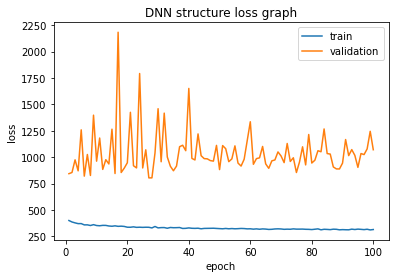

In [16]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x = train_loss_record
y = valid_loss_record
epoch = [i for i in range(1, n_epochs + 1)]

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('DNN structure loss graph')
plt.plot(epoch, x, label = 'train')
plt.plot(epoch, y, label = 'validation')
plt.legend()
plt.show()